# Fine-Tuning a VLM 

This notebook demonstrates how to fine-tune the `HuggingFaceTB/SmolVLM-Instruct` model using the `SFTTrainer` from the `trl` library. The notebook cells run and will finetune the model. You can select your difficulty by trying out different datasets.

<div style='background-color: lightblue; padding: 10px; border-radius: 5px; margin-bottom: 20px; color:black'>
    <h2 style='margin: 0;color:blue'>Exercise: Fine-Tuning SmolVLM with SFTTrainer</h2>
    <p>Take a dataset from the Hugging Face hub and finetune a model on it. </p> 
    <p><b>Difficulty Levels</b></p>
    <p>🐢 Use the `HuggingFaceM4/ChartQA` dataset for SFT training run.</p>
    <p>🐕 Use the fine-tuned to model generate a response, and improve upon the base example.</p>
    <p>🦁 Try out the other datasets and show improvement.</p>
</div>

In [1]:
# Install the requirements in Google Colab
# !pip install transformers datasets trl huggingface_hub

# Authenticate to Hugging Face
from huggingface_hub import login
login()

# for convenience you can create an environment variable containing your hub token as HF_TOKEN

In [2]:
# Import dependencies

import torch
import os
from transformers import AutoProcessor, AutoModelForVision2Seq, BitsAndBytesConfig
from transformers.image_utils import load_image

In [3]:

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

quantization_config = BitsAndBytesConfig(load_in_4bit=True, 
                                         bnb_4bit_use_double_quant=True, 
                                         bnb_4bit_quant_type="nf4", 
                                         bnb_4bit_compute_dtype=torch.bfloat16)
model_name = "HuggingFaceTB/SmolVLM-Instruct"
model = AutoModelForVision2Seq.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    torch_dtype=torch.bfloat16,
).to(device)
processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")

# Set our name for the finetune to be saved &/ uploaded to
finetune_name = "SmolVLM-FT-MyDataset"
finetune_tags = ["smol-course", "module_5"]

## Dataset Preparation

We will load a sample dataset and format it for training. The dataset should be structured with input-output pairs, where each input is a prompt and the output is the expected response from the model.

**TRL will format input messages based on the model's chat templates.** They need to be represented as a list of dictionaries with the keys: `role` and `content`,.

In [4]:
# Load a sample dataset
from datasets import load_dataset

# TODO: define your dataset and config using the path and name parameters
dataset_name = "HuggingFaceM4/ChartQA"
ds = load_dataset(path=dataset_name)
ds["train"] = ds["train"].select(range(100))  # Уменьши потому что ужесно долго
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'query', 'label', 'human_or_machine'],
        num_rows: 100
    })
    val: Dataset({
        features: ['image', 'query', 'label', 'human_or_machine'],
        num_rows: 1920
    })
    test: Dataset({
        features: ['image', 'query', 'label', 'human_or_machine'],
        num_rows: 2500
    })
})

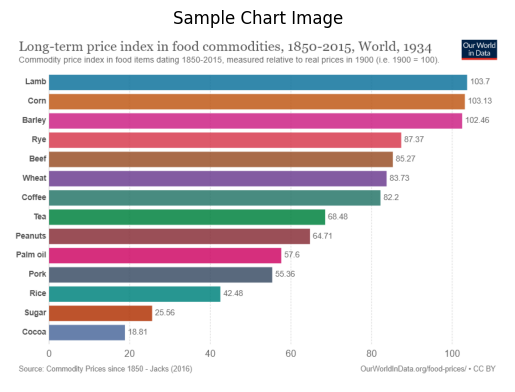

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=850x600 at 0x732AB819D4D0>, 'query': 'How many food item is shown in the bar graph?', 'label': ['14'], 'human_or_machine': 0, 'image_size': ((850, 600),)}
Query: How many food item is shown in the bar graph?
Expected Answer: 14
Model Prediction: User:<image>How many food item is shown in the bar graph?
11


In [7]:
import matplotlib.pyplot as plt
sample = ds['test'][0]

# Display the structure of a single sample
sample['image_size'] = sample['image'].size,

# Visualize the image and related metadata
plt.imshow(sample['image'])
plt.axis("off")
plt.title("Sample Chart Image")
plt.show()

print(sample)

# Preprocess the sample
prompt = [{"role": "user", "content": [{"type": "image"}, {"type": "text", "text": sample["query"]}]}]
formatted_query = processor.apply_chat_template(prompt, tokenize=False)

inputs = processor(
    images=sample["image"], 
    text=formatted_query, 
    return_tensors="pt"
).to(device)
inputs = {key: val.to(device, dtype=torch.bfloat16) if val.dtype == torch.float else val.to(device) for key, val in inputs.items()}

# Generate predictions
with torch.no_grad():
    outputs = model.generate(**inputs,
                             max_length=1600)

# Decode the prediction
prediction = processor.batch_decode(outputs, skip_special_tokens=True)

# Display the result
print(f"Query: {sample['query']}")
print(f"Expected Answer: {sample['label'][0]}")
print(f"Model Prediction: {prediction[0]}")

## Set Up LoRA

In [8]:
from peft import LoraConfig, get_peft_model

# Configure LoRA
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias="none",
    target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM",
)

# Apply PEFT model adaptation
peft_model = get_peft_model(model, peft_config)

# Print trainable parameters
peft_model.print_trainable_parameters()

trainable params: 2,568,192 || all params: 2,248,841,072 || trainable%: 0.1142


## Configuring the Trainer

The `Trainer` is configured with various parameters that control the training process. These include the number of training steps, batch size, learning rate, and evaluation strategy. Adjust these parameters based on your specific requirements and computational resources.

In [7]:
def collate_fn(examples):
    # System message template for the VLM
    system_message = """You are a Vision Language Model specialized in interpreting visual data from chart images.
    Your task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.
    The charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.
    Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."""

    # Initialize lists for text and image inputs
    text_inputs = []
    image_inputs = []

    # Process all examples in one loop
    for example in examples:
        # Format the chat structure for the processor
        formatted_example = {
            "messages": [
                {
                    "role": "system",
                    "content": [{"type": "text", "text": system_message}],
                },
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "image",
                        },
                        {
                            "type": "text",
                            "text": example["query"],
                        },
                    ],
                },
            ]
        }
        # Apply chat template and strip extra spaces
        text_inputs.append(processor.apply_chat_template(formatted_example["messages"], tokenize=False).strip())
        
        # Ensure images are in RGB mode
        image = example["image"]
        if image.mode != 'RGB':
            image = image.convert('RGB')
        image_inputs.append( [image] )

    # Tokenize the texts and process the images
    batch = processor(
        text=text_inputs,
        images=image_inputs,
        return_tensors="pt",
        padding=True
    )

    # Clone input IDs for labels
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100  # Mask padding tokens in labels

    # Ensure image_token is converted to string if it is an AddedToken
    # In some processor, processor.image_token return a list for each image.
    # TODO: AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct") only have one ?
    image_token_id = processor.tokenizer.convert_tokens_to_ids(str(processor.image_token))

    # Mask image token IDs in the labels
    labels[labels == image_token_id] = -100

    # Add labels back to the batch
    batch["labels"] = labels


    return batch


In [8]:
from trl import SFTConfig, SFTTrainer

import wandb
wandb.init(project="smoltalk-lora-tuning", mode="offline")

# Configure the Trainer
training_args = SFTConfig(
    output_dir="sft_output",  # Directory to save the model
    num_train_epochs=3,                     # number of training epochs
    per_device_train_batch_size=1,          # batch size per device during training
    gradient_accumulation_steps=16,         # number of steps before performing a backward/update pass
    gradient_checkpointing=True,            # use gradient checkpointing to save memory
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=5,                        # log every 10 steps
    save_strategy="epoch",                  # save checkpoint every epoch
    learning_rate=2e-4,                     # learning rate, based on QLoRA paper
    bf16=True,                              # use bfloat16 precision
    tf32=True,                              # use tf32 precision
    max_grad_norm=0.3,                      # max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                      # warmup ratio based on QLoRA paper
    lr_scheduler_type="constant",           # use constant learning rate scheduler
    push_to_hub=True,                       # push model to hub
    gradient_checkpointing_kwargs = {"use_reentrant": False}, # use reentrant checkpointing
    # dataloader_num_workers=16, 
    dataset_text_field="", # need a dummy field for collator
    dataset_kwargs = {"skip_prepare_dataset": True}, # important for collator
    remove_unused_columns = False                    # necessary else features except label will be removed
)
# Initialize the Trainer
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    data_collator=collate_fn,
    peft_config=peft_config,
    tokenizer=processor.tokenizer,
)

# TODO: 🦁 🐕 align the SFTTrainer params with your chosen dataset. For example, if you are using the `bigcode/the-stack-smol` dataset, you will need to choose the `content` column`

/home/user/HuaProjects/Tookies/smol-course/.venv/lib/python3.11/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/home/user/HuaProjects/Tookies/smol-course/.venv/lib/python3.11/site-packages/peft/tuners/tuners_utils.py:168: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
/home/user/HuaProjects/Tookies/smol-course/.venv/lib/python3.11/site-packages/trl/trainer/sft_trainer.py:309: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within

## Training the Model

With the trainer configured, we can now proceed to train the model. The training process will involve iterating over the dataset, computing the loss, and updating the model's parameters to minimize this loss.

In [9]:
# Train the model
trainer.train()

# Save the model
trainer.save_model(f"./{finetune_name}")

# Save to the huggingface hub if login (HF_TOKEN is set)
if os.getenv("HF_TOKEN"):
    trainer.push_to_hub(tags=finetune_tags)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
/home/user/HuaProjects/Tookies/smol-course/.venv/lib/python3.11/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]


Step,Training Loss
5,1.641400
10,1.470600
15,1.323500
20,1.197100


/home/user/HuaProjects/Tookies/smol-course/.venv/lib/python3.11/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
/home/user/HuaProjects/Tookies/smol-course/.venv/lib/python3.11/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.
wandb: WARNING URL not available in offline run


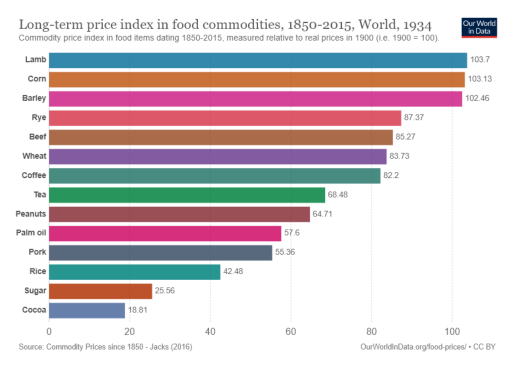

Query: How many food item is shown in the bar graph?
Expected Answer: 14
Model Prediction: User:<image>How many food item is shown in the bar graph?
Answer: 12.


In [10]:
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor
from peft import PeftModel

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

model_name = "HuggingFaceTB/SmolVLM-Instruct"
processor = AutoProcessor.from_pretrained(model_name)
base_model = AutoModelForVision2Seq.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
).to(device)


finetune_name = "./SmolVLM-FT-MyDataset"
model = PeftModel.from_pretrained(base_model, finetune_name).to(device)


model.eval()

dataset_name = "HuggingFaceM4/ChartQA"
ds = load_dataset(path=dataset_name)
sample = ds['test'][0]  

plt.imshow(sample['image'])
plt.axis("off")
plt.show()

prompt = [{"role": "user", "content": [{"type": "image"}, {"type": "text", "text": sample["query"]}]}]
formatted_query = processor.apply_chat_template(prompt, tokenize=False)

inputs = processor(
    images=sample["image"],
    text=formatted_query,
    return_tensors="pt"
).to(device)


inputs = {key: val.to(device, dtype=torch.bfloat16) if val.dtype == torch.float else val.to(device) for key, val in inputs.items()}


with torch.no_grad():
    outputs = model.generate(**inputs, max_length=1600)


prediction = processor.batch_decode(outputs, skip_special_tokens=True)[0]


print(f"Query: {sample['query']}")
print(f"Expected Answer: {sample['label'][0]}")
print(f"Model Prediction: {prediction}")

In [ ]:
from IPython.display import display, HTML
display(HTML("<h2>Kernel will shut down...</h2>"))

import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True) 

{'status': 'ok', 'restart': True}

wandb: 
wandb: You can sync this run to the cloud by running:
wandb: wandb sync /home/user/HuaProjects/Tookies/smol-course/5_vision_language_models/notebooks/wandb/offline-run-20250530_213456-2zh5tko8
wandb: Find logs at: wandb/offline-run-20250530_213456-2zh5tko8/logs


: 

## 💐 You're done!

This notebook provided a step-by-step guide to fine-tuning the `HuggingFaceTB/SmolVLM` model using the `SFTTrainer`. By following these steps, you can adapt the model to perform specific tasks more effectively. If you want to carry on working on this course, here are steps you could try out:

- Try this notebook on a harder difficulty
- Review a colleagues PR
- Improve the course material via an Issue or PR.